# Chest X-ray Disease Identification using Deep Learning

<a name='1'></a>
## 1. Import Packages and Functions¶



In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model


In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# exploring the data

In [2]:
data_df = pd.read_csv('./ChestX-ray14/Data_Entry_2017_v2020.csv')

In [3]:
data_df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [16]:
print(data_df.describe(include='all'))

             Image Index Finding Labels    Follow-up #     Patient ID  \
count             112120         112120  112120.000000  112120.000000   
unique            112120            836            NaN            NaN   
top     00000001_000.png     No Finding            NaN            NaN   
freq                   1          60361            NaN            NaN   
mean                 NaN            NaN       8.573751   14346.381743   
std                  NaN            NaN      15.406320    8403.876972   
min                  NaN            NaN       0.000000       1.000000   
25%                  NaN            NaN       0.000000    7310.750000   
50%                  NaN            NaN       3.000000   13993.000000   
75%                  NaN            NaN      10.000000   20673.000000   
max                  NaN            NaN     183.000000   30805.000000   

          Patient Age Patient Gender View Position  OriginalImage[Width  \
count   112120.000000         112120        1121

In [32]:
data_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')

No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Atelectasis|Effusion         1165
Pleural_Thickening           1126
Cardiomegaly                 1093
Name: Finding Labels, dtype: int64
count       13.000000
mean      7135.615385
std      16157.342580
min       1093.000000
25%       1310.000000
50%       2139.000000
75%       3955.000000
max      60361.000000
Name: Finding Labels, dtype: float64


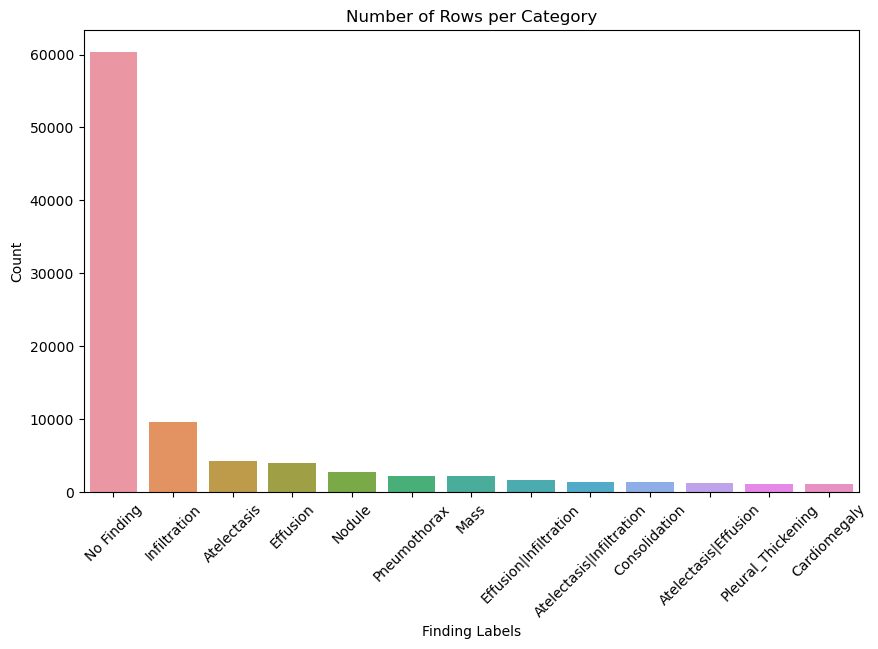

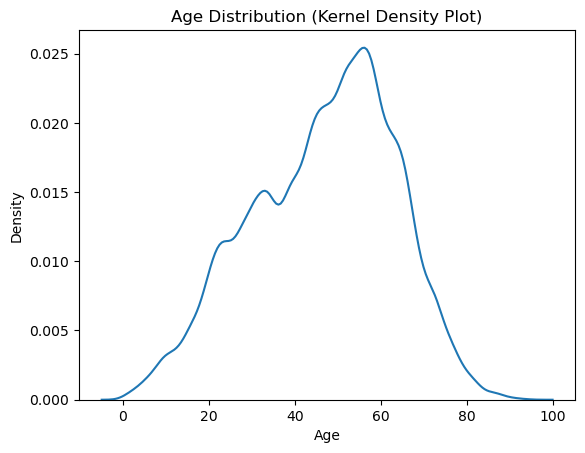

In [45]:
for column in data_df.columns:
    if column in ['Image Index']:
        continue
    if column in ['Patient Age']:
        sns.kdeplot(data=data_df, x='Patient Age')
        plt.title('Age Distribution (Kernel Density Plot)')
        plt.xlabel('Age')
        plt.ylabel('Density')
        continue
    if column in ['Finding Labels']:
        threshold_count =1000
        # Count the number of rows per category
        category_counts = data_df[column].value_counts()
        category_counts = category_counts[category_counts >= threshold_count]
        # Sort the categories by count in descending order
        category_counts = category_counts.sort_values(ascending=False)
        print(category_counts)
        print(category_counts.describe())
        plt.figure(figsize=(10, 6))
        sns.barplot(x=category_counts.index, y=category_counts.values)
        plt.title('Number of Rows per Category')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
        continue
    # sns.histplot(data=data_df[column], kde=True)
    # plt.title(f"Distribution of {column}")
    # plt.show()



In [63]:
df.head()

,Image Index,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
Patient ID,,,,,,,,,,,,,,,,,
1,00000001_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,00000001_000.png
1,00000001_001.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,00000001_001.png
1,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,00000001_002.png
2,00000002_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,00000002_000.png
3,00000003_000.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,00000003_000.png


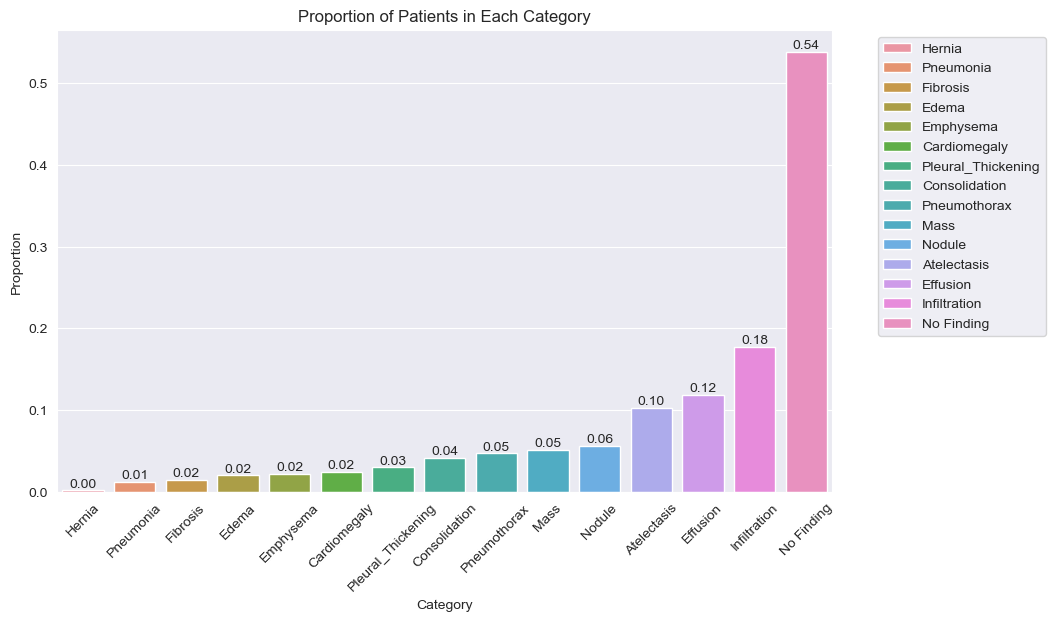

In [163]:
df = pd.read_csv('./ChestX-ray14/train_df.csv')
# test_df = pd.read_csv('./ChestX-ray14/test.csv')
# train_df = pd.read_csv('./ChestX-ray14/train-small.csv')
# valid_df = pd.read_csv('./ChestX-ray14/valid-small.csv')
# df = pd.concat([test_df, train_df,valid_df], ignore_index=True)
df.columns
# Image Index,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
# df = df.drop(['FilePath','Image Index'], axis=1)
# df = df.drop(['Image'], axis=1)
# df.head()
# Set the PatientID column as the index
# df['Patient ID'] = df['Image'].str.split('_').str.get(0)
df = df.drop(['Image Index','FilePath'], axis=1)
df.set_index('Patient ID', inplace=True)

# Calculate the proportion of patients in each category
category_proportions = df.sum() / len(df)
category_proportions = category_proportions.sort_values()

# Plot the stacked bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=category_proportions.index, y=category_proportions.values,label=category_proportions.index)
plt.title('Proportion of Patients in Each Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Add labels at the bars
for i, v in enumerate(category_proportions.values):
    ax.text(i, v, '{:.2f}'.format(v), ha='center', va='bottom')
plt.xlabel('Category')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()

In [ ]:
correlations = df[['Age', 'Finding1', 'Finding2', 'Finding3']].corr()['Age'][1:]

# Plot the correlation as grouped bars
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Correlation between Age and Findings')
plt.xlabel('Findings')
plt.ylabel('Correlation')
plt.show()

In [115]:
import pandas as pd

# Assuming you have two data frames: df1 and df2
df1 = pd.read_csv('./ChestX-ray14/Data_Entry_2017_v2020.csv')
# df1.head()
df2 = pd.read_csv('./ChestX-ray14/train_df.csv')
# df2.head()
# Merge the data frames using an outer join on the 'ID' column
merged_df = pd.merge(df1, df2, on='Image Index', how='outer')
merged_df = merged_df.drop(['FilePath'],axis=1)
print(merged_df.head())


        Image Index          Finding Labels  Follow-up #  Patient ID_x  \
0  00000001_000.png            Cardiomegaly            0             1   
1  00000001_001.png  Cardiomegaly|Emphysema            1             1   
2  00000001_002.png   Cardiomegaly|Effusion            2             1   
3  00000002_000.png              No Finding            0             2   
4  00000003_001.png                  Hernia            0             3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x  ...  Infiltration  Mass  Nodule  Atelectasis  \
0           

In [116]:
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID_x',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Patient ID_y',
       'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'],
      dtype='object')

In [117]:
merged_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID_x',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Patient ID_y',
       'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


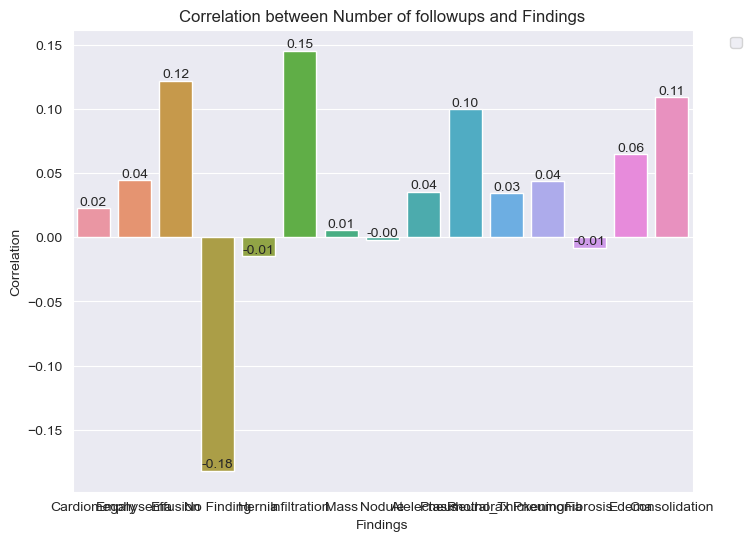

In [118]:

correlations = merged_df[['Follow-up #',
       'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation']].corr()['Follow-up #'][1:]

# Plot the correlation as grouped bars
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=correlations.index, y=correlations.values)
for i, v in enumerate(correlations.values):
    ax.text(i, v, '{:.2f}'.format(v), ha='center', va='bottom')

plt.title('Correlation between Number of followups and Findings')
plt.xlabel('Findings')
plt.ylabel('Correlation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

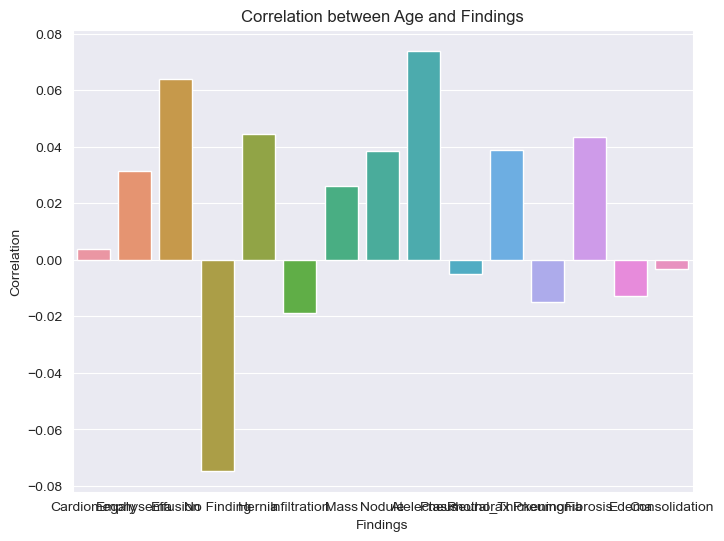

In [119]:
correlations = merged_df[['Patient Age',
       'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation']].corr()['Patient Age'][1:]

# Plot the correlation as grouped bars
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Correlation between Age and Findings')
plt.xlabel('Findings')
plt.ylabel('Correlation')
plt.show()

In [125]:
merged_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID_x',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Patient ID_y',
       'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation',
       'Disease'],
      dtype='object')

In [165]:

merged_df['Disease'] = np.where(merged_df['Finding Labels'] == 'No Finding', 0, 1)
# merged_df[['Disease','Patient Age']].corr()['Patient Age']
correlations = merged_df[['Disease','Follow-up #']].corr()['Follow-up #'][1:]
correlations.head()
# # Plot the correlation as grouped bars
# plt.figure(figsize=(8, 6))
# sns.barplot(x=correlations.index, y=correlations.values)
# plt.title('Correlation between Follow-up # and Findings')
# plt.xlabel('Findings')
# plt.ylabel('Correlation')
# plt.show()

Follow-up #    1.0
Name: Follow-up #, dtype: float64

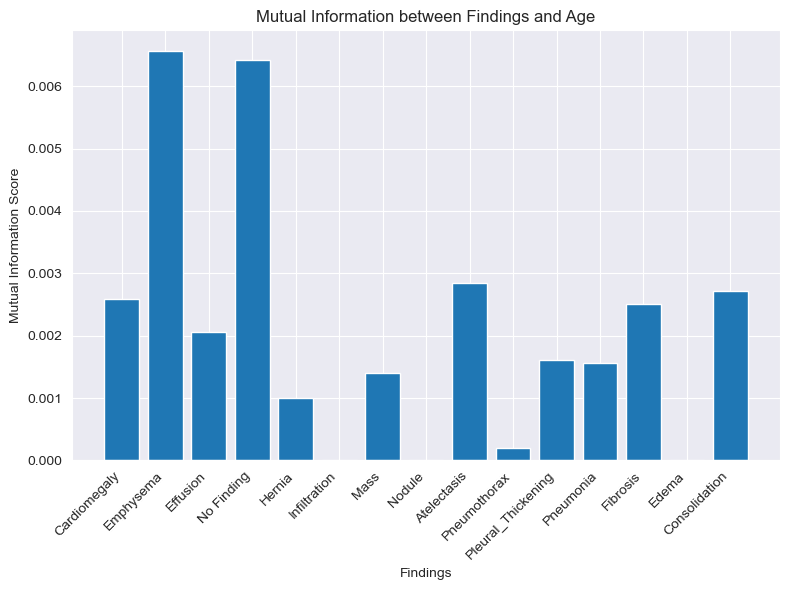

In [120]:
from sklearn.feature_selection import mutual_info_regression
df = merged_df.dropna()
X = df[[
       'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation']].dropna()
y = df['Patient Age']

# Calculate the mutual information scores
mi_scores = mutual_info_regression(X, y)

# Create a bar plot to visualize the mutual information scores
plt.figure(figsize=(8, 6))
plt.bar(X.columns, mi_scores)
plt.title('Mutual Information between Findings and Age')
plt.xlabel('Findings')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/9t/wzkngdzn78n84hdt1d1g29tc0000gn/T/ipykernel_3612/3956801449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender'] = df['Patient Gender'].replace({'M': 0, 'F': 1})


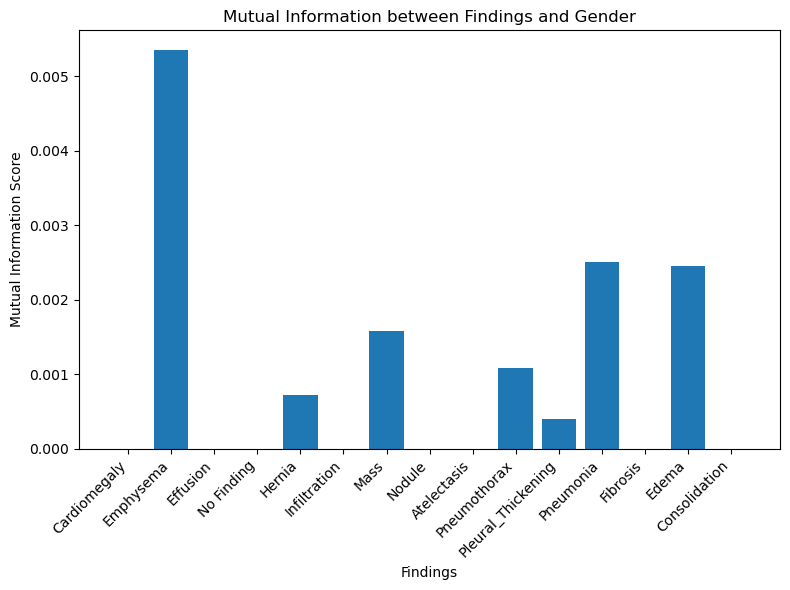

In [106]:
from sklearn.feature_selection import mutual_info_regression
df = merged_df.dropna()
X = df[[
       'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation']]
df['Gender'] = df['Patient Gender'].replace({'M': 0, 'F': 1})
# df.loc[:, 'Patient Gender'] = df['Patient Gender'].replace({'M': 0, 'F': 1})

y = df['Gender']

# Calculate the mutual information scores
mi_scores = mutual_info_regression(X, y)

# Create a bar plot to visualize the mutual information scores
plt.figure(figsize=(8, 6))
plt.bar(X.columns, mi_scores)
plt.title('Mutual Information between Findings and Gender')
plt.xlabel('Findings')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [114]:
merged_df


,Image Index,Finding Labels,Follow-up #,Patient ID_x,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,1,0,1,57,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,1,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,1,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,1,0,2,80,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_001.png,1,0,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,1,1,30801,38,M,PA,2048,2500,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
112116,00030802_000.png,1,0,30802,28,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,1,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,1,0,30804,29,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


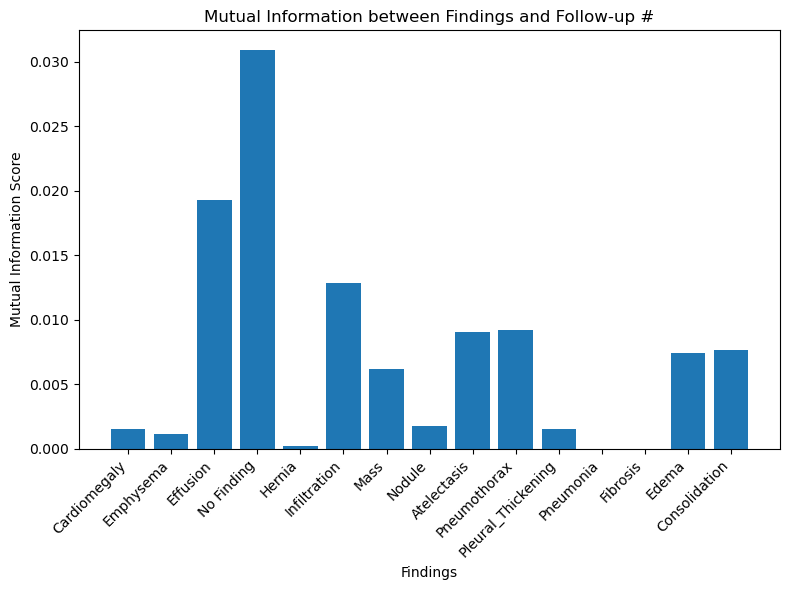

In [104]:
from sklearn.feature_selection import mutual_info_regression
df = merged_df.dropna()
X = df[[
       'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation']]
y = df['Follow-up #']

# Calculate the mutual information scores
mi_scores = mutual_info_regression(X, y)

# Create a bar plot to visualize the mutual information scores
plt.figure(figsize=(8, 6))
plt.bar(X.columns, mi_scores)
plt.title('Mutual Information between Findings and Follow-up #')
plt.xlabel('Findings')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [96]:
merged_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID_x',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Patient ID_y',
       'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'],
      dtype='object')

In [30]:
total_columns = data_df.columns
total_columns
# store numerical and categorical column in two different variables. It comes handy during visualizaion.
# num_col = data_df._get_numeric_data().columns
# cat_col = list(set(total_columns)-set(num_col))
# describe_num_df = data_df.describe(include=['int64','float64'])
# describe_num_df.reset_index(inplace=True)
# # To remove any variable from plot
# describe_num_df = describe_num_df[describe_num_df['index'] != 'count']
# for i in num_col:
#   if i in ['index']:
#     continue
#   sns.lineplot(x="index", y=i, data=describe_num_df)
#   plt.show()

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')

In [131]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    optimal_thresholds = []
    sensitivity = []
    specificity = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i] 
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred) # return 
            auc_roc_vals.append(auc_roc)
            fpr, tpr, thresholds = roc_curve(gt, pred)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            y_pred = pred > optimal_threshold
            acc = accuracy_score(gt, y_pred)
            prec = precision_score(gt, y_pred)
            rec = recall_score(gt, y_pred)
            f1_s = f1_score(gt, y_pred)
            accuracy.append(acc)
            precision.append(prec)
            recall.append(rec)
            f1.append(f1_s)
            optimal_thresholds.append(optimal_threshold) # find optimal thresholds https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
            optimal_tpr = round(tpr[optimal_idx],3)
            optimal_1_fpr = round(1 - fpr[optimal_idx],3)
#             print(f"Length of tpr tpr : {len(tpr)} \n Length of thresholds {len(thresholds)}")
#             print(f"optimal index : {optimal_idx} \n Optimal 1 - fpr : {optimal_1_fpr}")
            sensitivity.append(optimal_tpr)
            specificity.append(1-fpr[optimal_idx])
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--') # black dash line
            plt.plot(fpr, tpr,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals, optimal_thresholds, sensitivity, specificity, accuracy, precision, recall, f1



<a name='2'></a>
## 2 Load the Datasets

For this assignment, we will be using the ChestX-ray8 dataset (https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
 

In [132]:
#test_df = pd.read_csv(" /test.csv")
#test_df.head()
all_xray_df = pd.read_csv("ChestX-ray14/train_df.csv")
# all_xray_df.drop(['No Finding'], axis = 1, inplace = True)
all_xray_df.head()

,Image Index,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,00000001_000.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,00000001_000.png
1,00000001_001.png,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,00000001_001.png
2,00000001_002.png,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,00000001_002.png
3,00000002_000.png,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,00000002_000.png
4,00000003_000.png,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,00000003_000.png


In [133]:
all_xray_df.describe()


,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
count,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000
mean,14352.731484,0.024807,0.022447,0.118779,0.538069,0.002029,0.177619,0.051599,0.056480,0.103189,0.047317,0.030207,0.012775,0.015045,0.020525,0.041658
std,8404.535812,0.155538,0.148133,0.323530,0.498551,0.045002,0.382193,0.221217,0.230847,0.304207,0.212317,0.171156,0.112301,0.121733,0.141789,0.199808
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7317.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13996.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,20673.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30805.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [134]:
len(all_xray_df)

111863

In [135]:
patients = all_xray_df['Patient ID'].drop_duplicates()
len(patients)

30773

In [75]:
df = pd.read_csv('./ChestX-ray14/labels/test_list.txt')
# patients = df['PatientId'].drop_duplicates()
# print('number of patients in test',len(patients))
df.head()

,00011997_000.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0,00011997_001.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1,00011997_002.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2,00011997_003.png 0 0 1 0 0 0 0 0 0 0 0 0 0 0
3,00011997_004.png 0 1 1 1 0 0 0 0 0 0 0 0 0 0
4,00011997_005.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [72]:
df = pd.read_csv('./ChestX-ray14/train-small.csv')
patients = df['PatientId'].drop_duplicates()
print('number of patients in train small',len(patients))
# df.head()

number of patients in train small 928


In [73]:
df = pd.read_csv('./ChestX-ray14/valid-small.csv')
patients = df['PatientId'].drop_duplicates()
print('number of patients in valid small',len(patients))
# df.head()

number of patients in valid small 199


In [12]:
all_xray_df = all_xray_df[89485:] # 22378 images

In [137]:
all_xray_df.columns

Index(['Image Index', 'Patient ID', 'Cardiomegaly', 'Emphysema', 'Effusion',
       'No Finding', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
       'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation', 'FilePath'],
      dtype='object')

In [140]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<a name='2-2'></a>
### 2.1 Preparing Images

1. Normalize the mean and standard deviation of the data
3. Shuffle the input after each epoch.
4. Set the image size to be 320px by 320px

In [141]:
def get_generator(df, image_dir, x_col, y_cols, sample_size=100, batch_size=64, seed=1, target_w = 512, target_h = 512):
    
    print("getting testing generators...")
    
    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator

With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [142]:
IMAGE_DIR = "ChestX-ray14/images"
test_generator= get_generator(all_xray_df, IMAGE_DIR, "Image Index", labels)

getting testing generators...
Found 111863 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


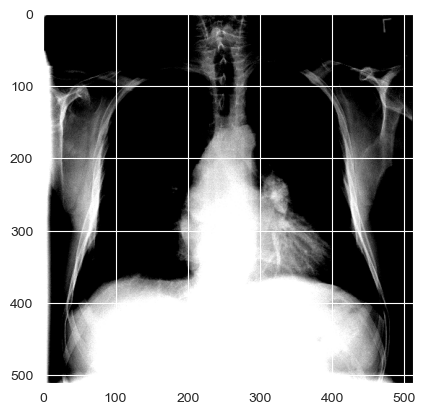

In [143]:
# peek into one item of the test generator
x, y = test_generator.__getitem__(0)
plt.imshow(x[0]);

<a name='3'></a>
## 3 Model Development

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

Now let's test our function with some simple cases. 

<a name='3-3'></a>
### 3.1 DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [86]:
# create the base pre-trained model
base_model = DenseNet121(weights='./ChestX-ray14/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [153]:
all_xray_df.head()

,Image Index,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,00000001_000.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,00000001_000.png
1,00000001_001.png,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,00000001_001.png
2,00000001_002.png,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,00000001_002.png
3,00000002_000.png,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,00000002_000.png
4,00000003_000.png,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,00000003_000.png


In [87]:
model.load_weights("./ChestX-ray14/pretrained_model.h5")

In [156]:
text_feature_dim = pd.read_csv('./ChestX-ray14/Data_Entry_2017_v2020.csv')
text_feature_dim = text_feature_dim.drop(['Finding Labels','Image Index'], axis=1)
text_feature_dim['OriginalImageHeight'] = text_feature_dim['Height]']
text_feature_dim['OriginalImageWidth'] = text_feature_dim['OriginalImage[Width']
text_feature_dim['OriginalImagePixelSpacingX'] = text_feature_dim['OriginalImagePixelSpacing[x']
text_feature_dim['OriginalImagePixelSpacingY'] = text_feature_dim['y]']

In [159]:
text_feature_dim = text_feature_dim.drop(['Height]','OriginalImage[Width', 'OriginalImagePixelSpacing[x','y]'],axis=1)
text_feature_dim

,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageHeight,OriginalImageWidth,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY
0,0,1,57,M,PA,2749,2682,0.143,0.143
1,1,1,58,M,PA,2729,2894,0.143,0.143
2,2,1,58,M,PA,2048,2500,0.168,0.168
3,0,2,80,M,PA,2048,2500,0.171,0.171
4,0,3,74,F,PA,2048,2500,0.168,0.168
...,...,...,...,...,...,...,...,...,...
112115,1,30801,38,M,PA,2500,2048,0.168,0.168
112116,0,30802,28,M,PA,2500,2048,0.168,0.168
112117,0,30803,42,F,PA,2500,2048,0.168,0.168
112118,0,30804,29,F,PA,2500,2048,0.168,0.168


In [161]:
merged_xray = text_feature_dim.merge(all_xray_df,on='Patient ID').head()

In [ ]:
import pandas as pd
from tensorflow import keras
from keras.applications.densenet import DenseNet121
from keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate

# all_xray_df = pd.read_csv("ChestX-ray14/train_df.csv")
# text_feature_dim = pd.read_csv('./ChestX-ray14/Data_Entry_2017_v2020.csv')

IMAGE_DIR = "ChestX-ray14/images"
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
image_width = 320
image_height = 320
num_channels = 3
# Define the image input layer
image_input = Input(shape=(image_width, image_height, num_channels))

# Define the text input layer
text_input = Input(shape=(text_feature_dim,))

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='./ChestX-ray14/densenet.hdf5', include_top=False)

# Obtain the output of the base model
x = base_model(image_input)

# Add global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Concatenate the output with the text input
merged_output = Concatenate()([x, text_input])

# Add a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(merged_output)

# Create the model
model = keras.Model(inputs=[image_input, text_input], outputs=predictions)

# Load the weights
model.load_weights("./ChestX-ray14/pretrained_model.h5")

# Generate the test data (image and text)
test_image_data = get_image_data(all_xray_df, IMAGE_DIR, "Image Index")
test_text_data = get_text_data(all_xray_df)  # Replace with your text data

# Predict the labels
predicted_vals = model.predict([test_image_data, test_text_data], batch_size=16, verbose=1)


<a name='4'></a>
## 4 Prediction and Evaluation

In [88]:
predicted_vals = model.predict(test_generator, steps = len(test_generator),batch_size=16, verbose = 1)
# 22378 images with batch size of 8

2023-07-01 21:56:59.831476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1748/1748 [==============================] - 31658s 18s/step


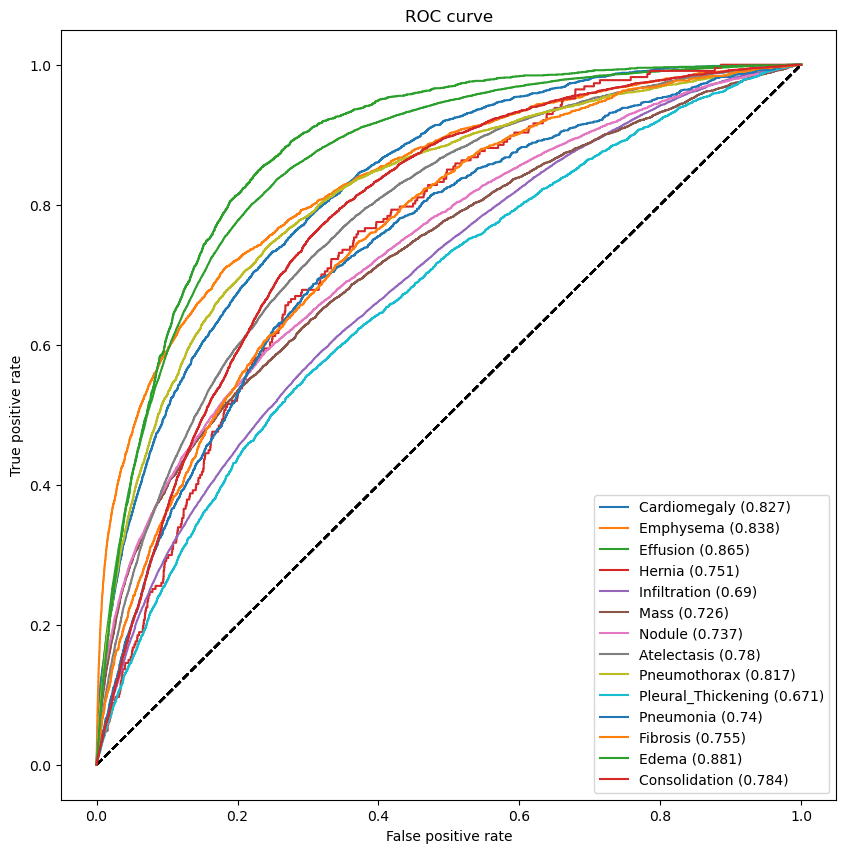

In [89]:
# get roc curve
from statistics import mean
auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1 = get_roc_curve(labels, predicted_vals, test_generator)


In [90]:
# get table of auc_rocs
from tabulate import tabulate
table = zip(labels, auc_rocs)
print(f"Mean AUC : {mean(auc_rocs)}")
print(tabulate(table, headers = ['Pathology', 'AUC'], tablefmt = 'fancy_grid'))

Mean AUC : 0.7760060803279273
╒════════════════════╤══════════╕
│ Pathology          │      AUC │
╞════════════════════╪══════════╡
│ Cardiomegaly       │ 0.826823 │
├────────────────────┼──────────┤
│ Emphysema          │ 0.83831  │
├────────────────────┼──────────┤
│ Effusion           │ 0.864746 │
├────────────────────┼──────────┤
│ Hernia             │ 0.751385 │
├────────────────────┼──────────┤
│ Infiltration       │ 0.690105 │
├────────────────────┼──────────┤
│ Mass               │ 0.726408 │
├────────────────────┼──────────┤
│ Nodule             │ 0.737423 │
├────────────────────┼──────────┤
│ Atelectasis        │ 0.780365 │
├────────────────────┼──────────┤
│ Pneumothorax       │ 0.817068 │
├────────────────────┼──────────┤
│ Pleural_Thickening │ 0.67075  │
├────────────────────┼──────────┤
│ Pneumonia          │ 0.740423 │
├────────────────────┼──────────┤
│ Fibrosis           │ 0.755389 │
├────────────────────┼──────────┤
│ Edema              │ 0.881254 │
├─────────────────

In [92]:
from tabulate import tabulate
table = zip(labels, auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1)
print(tabulate(table, headers = ['Pathology', 'AUC', 'Threshold Value', 'Sensitivity', 'Specificity', 'Accuracy', 'Precision', 'Recall', 'F1 Score'], tablefmt = 'fancy_grid'))

╒════════════════════╤══════════╤═══════════════════╤═══════════════╤═══════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Pathology          │      AUC │   Threshold Value │   Sensitivity │   Specificity │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════════════╪══════════╪═══════════════════╪═══════════════╪═══════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Cardiomegaly       │ 0.826823 │          0.391777 │         0.733 │      0.750431 │   0.749989 │  0.0694853  │ 0.732613 │ 0.126932   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Emphysema          │ 0.83831  │          0.546262 │         0.711 │      0.816483 │   0.814112 │  0.0816821  │ 0.710872 │ 0.146528   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Effusion           │ 0.864746 │        

In [93]:
print(predicted_vals[0:100][0])


[0.69553196 0.44214913 0.5256247  0.64281815 0.5671154  0.4985391
 0.46717858 0.5099157  0.23558338 0.6709318  0.53963566 0.5908621
 0.30399606 0.5043828 ]
